# **Objective**

**By analyzing these Bangalore house data we will determine the approximate price for the houses.**

# Part 1 | Data Preprocessing


### Importing Necessary Libraries

In [215]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import pickle

## Part 1.1.1 | Load the Dataset 

In [216]:
df = pd.read_csv("Bengaluru_House_Data.csv")

### Initial Data Analysis


In [217]:
df.shape

(13320, 9)

In [218]:
df.head(10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [220]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [221]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bath,13247.0,2.692610,1.341458,1.0,2.0,2.0,3.0,40.0
balcony,12711.0,1.584376,0.817263,0.0,1.0,2.0,2.0,3.0
price,13320.0,112.565627,148.971674,8.0,50.0,72.0,120.0,3600.0


In [222]:
df.describe(include = 'object').T

,count,unique,top,freq
area_type,13320,4,Super built-up Area,8790
availability,13320,81,Ready To Move,10581
location,13319,1305,Whitefield,540
size,13304,31,2 BHK,5199
society,7818,2688,GrrvaGr,80
total_sqft,13320,2117,1200,843


In [223]:
df.duplicated().sum()

529

In [224]:
df['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

## Part 1.1.2 | Perform EDA

<Axes: xlabel='area_type'>

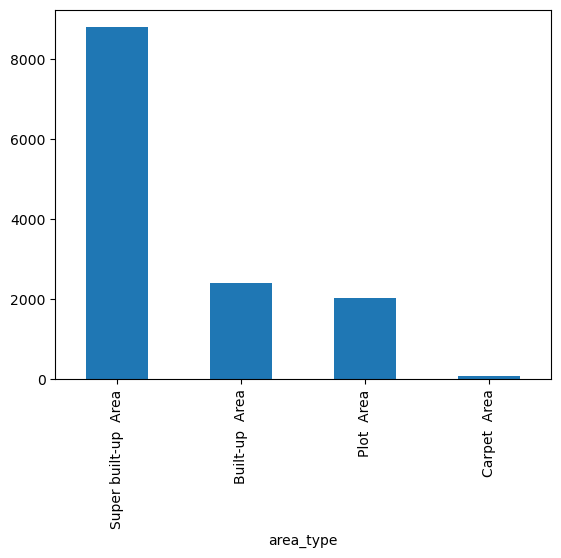

In [225]:
df.area_type.value_counts().plot(kind='bar')

<Axes: xlabel='bath'>

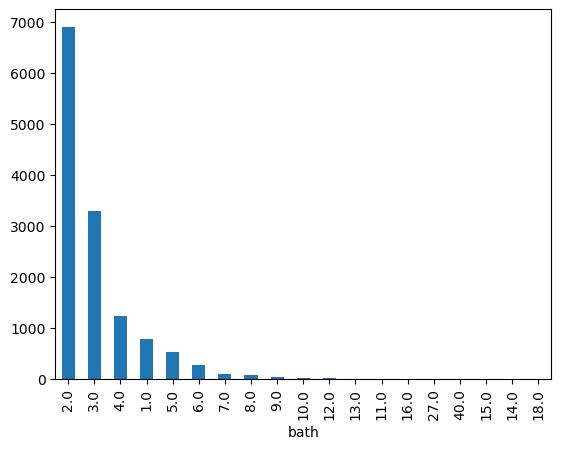

In [226]:
df.bath.value_counts().plot(kind='bar')

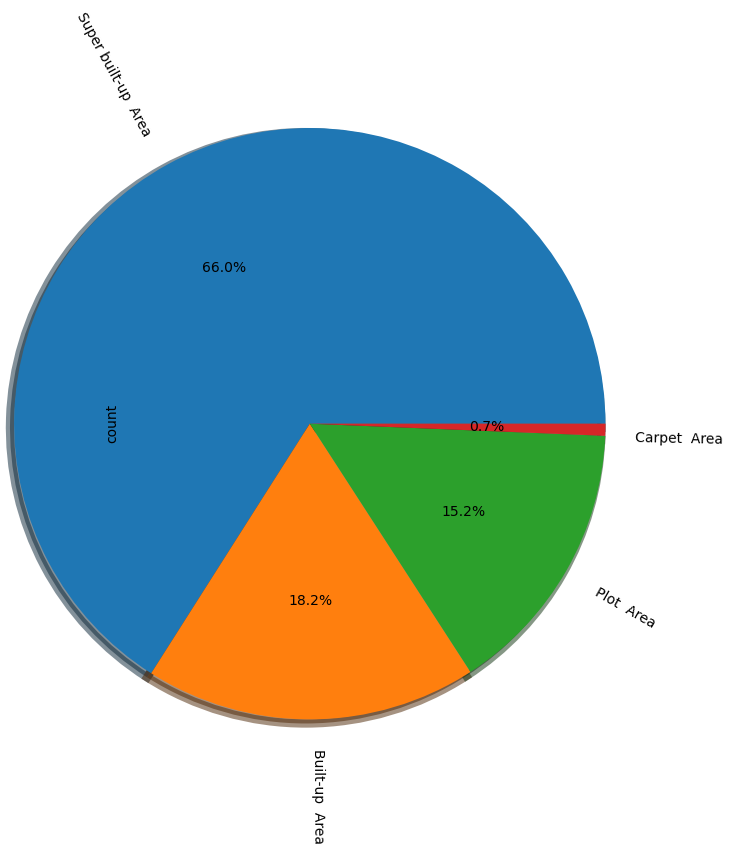

In [227]:
(df["area_type"].value_counts()).plot.pie(autopct="%.1f%%", shadow=True,rotatelabels=True, wedgeprops={'linewidth': 6}, radius=2)
plt.show()

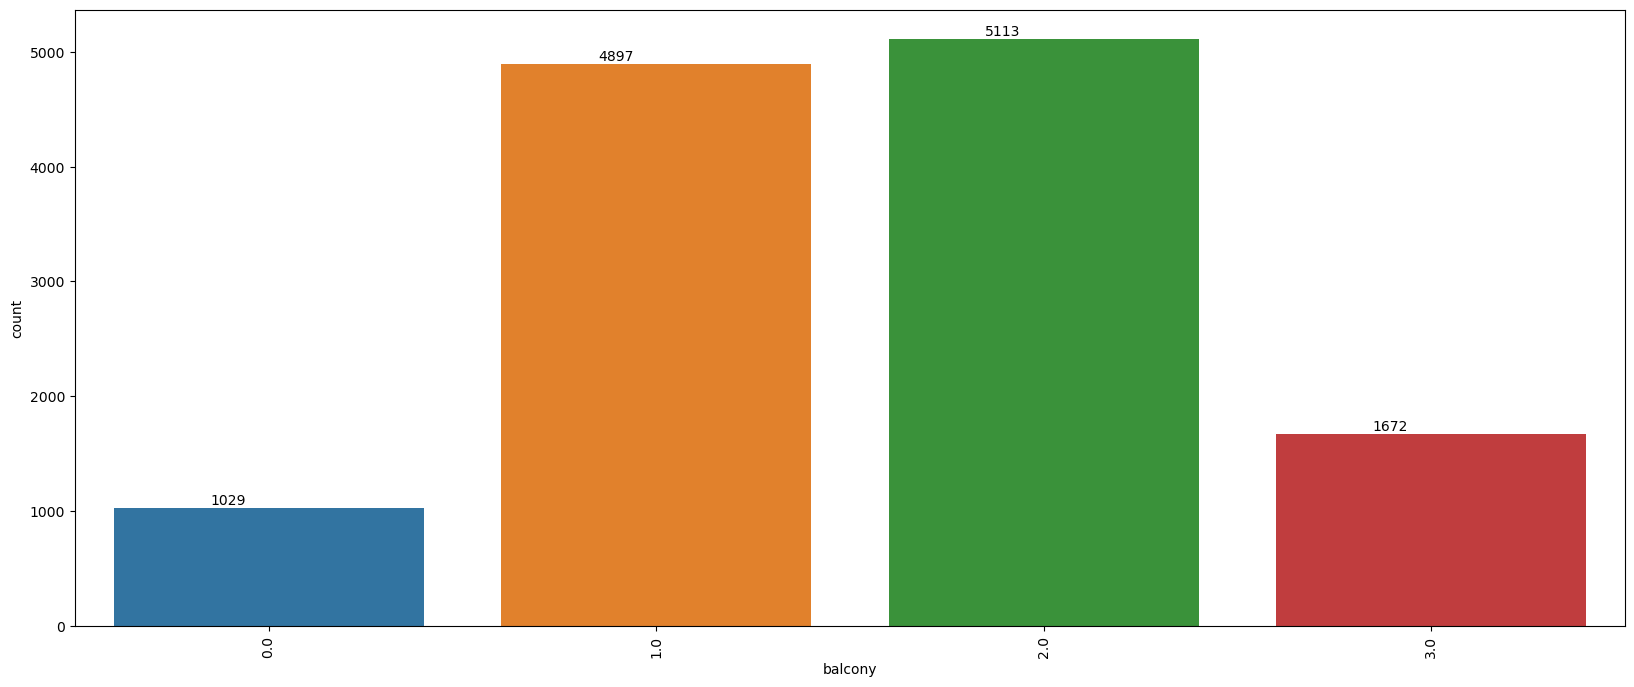

In [228]:
plt.figure(figsize = (20,8))
ax=sns.countplot(x = 'balcony', data = df)
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va = 'bottom', color = 'black')

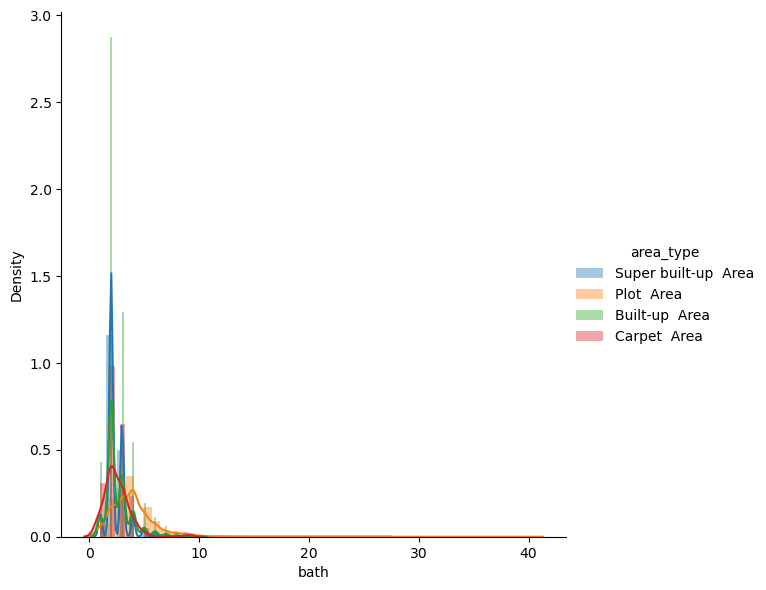

In [229]:
import warnings
warnings.filterwarnings('ignore')

sns.FacetGrid(df, hue='area_type', height=6).map(sns.distplot, 'bath').add_legend()
plt.show()

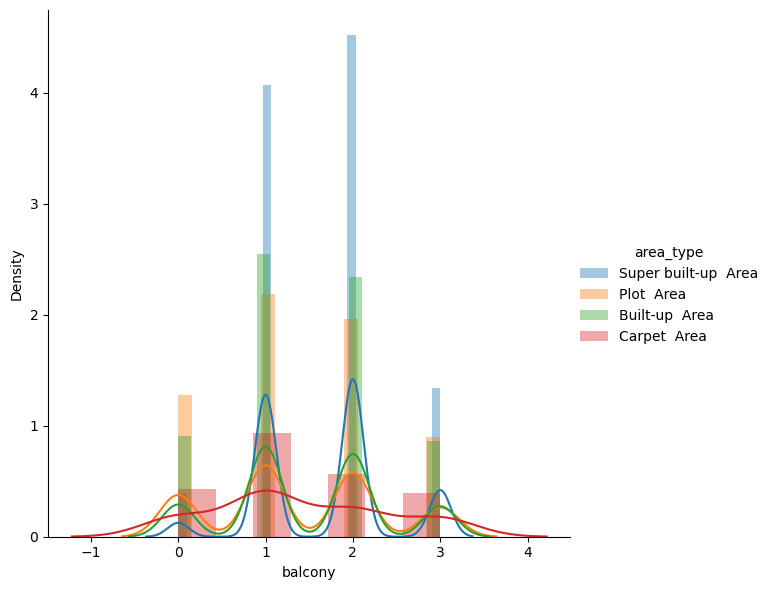

In [230]:
sns.FacetGrid(df, hue='area_type', height=6).map(sns.distplot, 'balcony').add_legend()
plt.show()

## Feature Selection


In [231]:
df2 = df.drop(['area_type','society','balcony','availability'],axis = 1)

## Part 1.2 | Handle Missing Value 


In [232]:
df2.head(3)

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00


In [233]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [234]:
imputer1 = SimpleImputer(strategy='most_frequent')

In [235]:
imputer2 = SimpleImputer(strategy='median')

In [236]:
df2[['location','size']] = imputer1.fit_transform(df2[['location','size']])

In [237]:
df2.isnull().sum()

location       0
size           0
total_sqft     0
bath          73
price          0
dtype: int64

In [238]:
df2['bath'].value_counts()

bath
2.0     6908
3.0     3286
4.0     1226
1.0      788
5.0      524
6.0      273
7.0      102
8.0       64
9.0       43
10.0      13
12.0       7
13.0       3
11.0       3
16.0       2
27.0       1
40.0       1
15.0       1
14.0       1
18.0       1
Name: count, dtype: int64

In [239]:
df2['bath'] = imputer2.fit_transform(df2[['bath']])

In [240]:
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

## Feature Engineering

In [241]:
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [242]:
df2['size'].value_counts()

size
2 BHK         5215
3 BHK         4310
4 Bedroom      826
4 BHK          591
3 Bedroom      547
1 BHK          538
2 Bedroom      329
5 Bedroom      297
6 Bedroom      191
1 Bedroom      105
8 Bedroom       84
7 Bedroom       83
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 BHK           2
11 Bedroom       2
10 BHK           2
14 BHK           1
13 BHK           1
12 Bedroom       1
27 BHK           1
43 Bedroom       1
16 BHK           1
19 BHK           1
18 Bedroom       1
Name: count, dtype: int64

From the above we can clearly see that Bedroom is represented with 2 different methods. One is BHK and the other one is Bedroom. So we are making a new column called BHK and we are discarding all the units (like BHK, Bedroom).

In [243]:
df2['bhk'] = df2['size'].str.split(' ',expand = True)[0]

In [244]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [245]:
df2['bhk'].unique()

array(['2', '4', '3', '6', '1', '8', '7', '5', '11', '9', '27', '10',
       '19', '16', '43', '14', '12', '13', '18'], dtype=object)

In [246]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13320 non-null  object 
 1   size        13320 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13320 non-null  float64
 4   price       13320 non-null  float64
 5   bhk         13320 non-null  object 
dtypes: float64(2), object(4)
memory usage: 624.5+ KB


In [247]:
df2['bhk'] = df2['bhk'].astype(str).str.strip()

In [248]:
df2['bhk'] = df2['bhk'].astype('category')

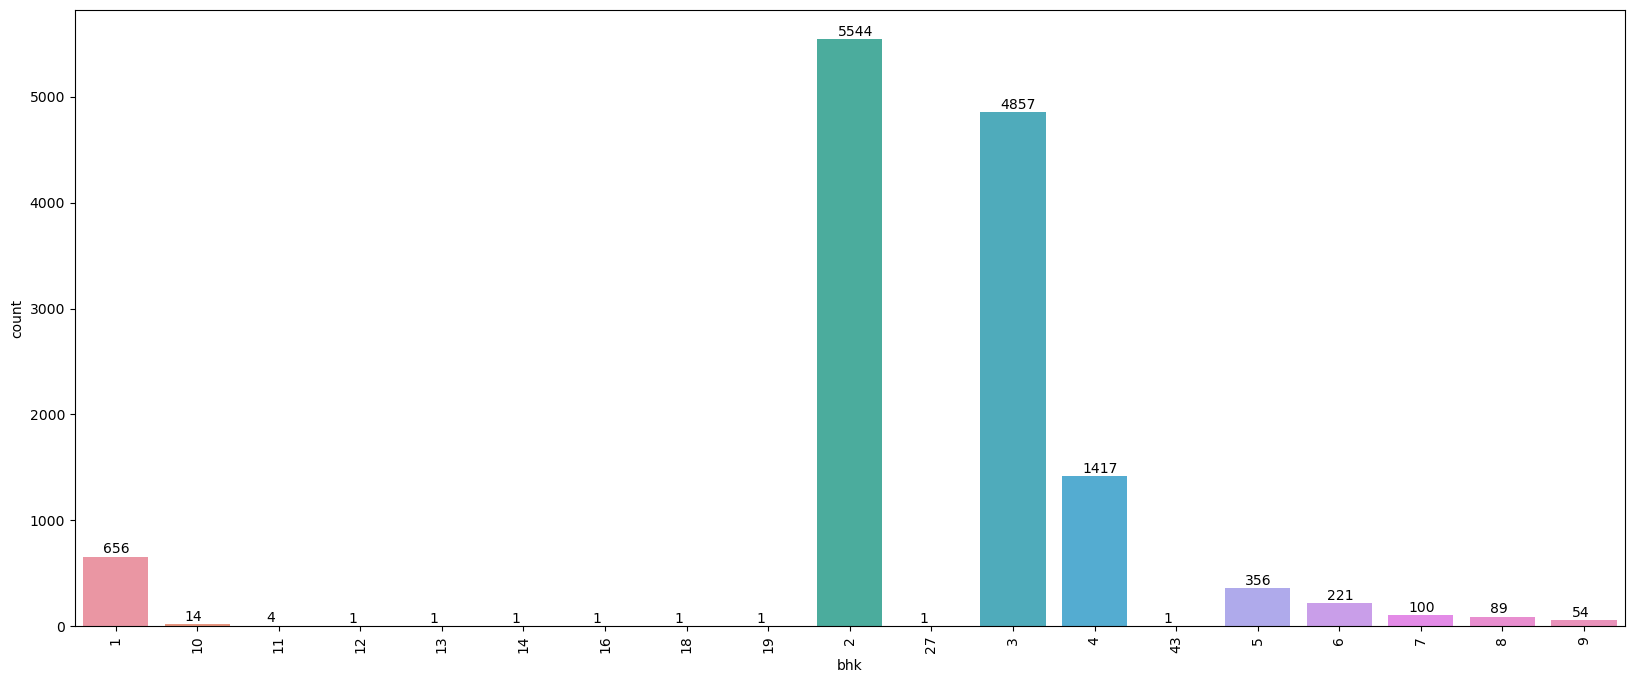

In [249]:
plt.figure(figsize=(20,8))
ax = sns.countplot(x='bhk', data=df2)
plt.xticks(rotation=90)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.25, p.get_height() + 1), va='bottom', color='black')

plt.show()

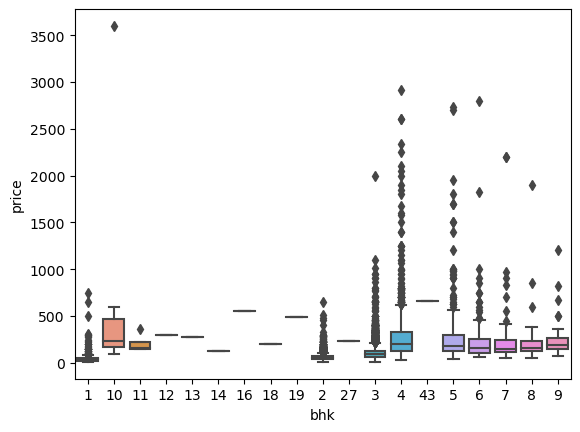

In [250]:
sns.boxplot(x = 'bhk', y = 'price', data = df2)
plt.show()

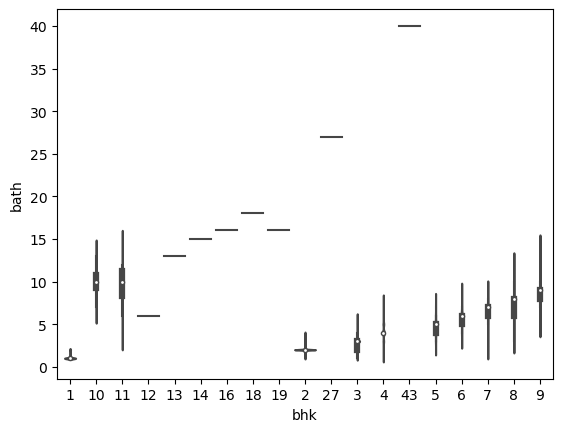

In [251]:
sns.violinplot(x='bhk', y = 'bath', data = df2)
plt.show()

In [252]:
df2['bhk'] = pd.to_numeric(df2['bhk'])

In [253]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13320 non-null  object 
 1   size        13320 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13320 non-null  float64
 4   price       13320 non-null  float64
 5   bhk         13320 non-null  int64  
dtypes: float64(2), int64(1), object(3)
memory usage: 624.5+ KB


In [254]:
df2[df2.bhk > 20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [255]:
df2.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [256]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [257]:
df2[~df2['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
224,Devanahalli,3 BHK,1520 - 1740,2.0,74.820,3
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2


From the above we can see that total_sqft can be a range (say, 3090-5002). For such cases we can just take average of the minimum and maximum value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. So, we are going to just drop such corner cases to keep things simple.

Converting Sq.Ft to Number

In [258]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+ float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [259]:
df3 = df2.copy()
df3.total_sqft = df3.total_sqft.apply(convert_sqft_to_num)

In [260]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [261]:
df3.loc[224]

location      Devanahalli
size                3 BHK
total_sqft         1630.0
bath                  2.0
price               74.82
bhk                     3
Name: 224, dtype: object

In [262]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13320 non-null  object 
 1   size        13320 non-null  object 
 2   total_sqft  13274 non-null  float64
 3   bath        13320 non-null  float64
 4   price       13320 non-null  float64
 5   bhk         13320 non-null  int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 624.5+ KB


In [263]:
df4 = df3.copy()
df4['price_per_sqft'] = df4['price']*100000/df4['total_sqft']

In [264]:
df4.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


Here, we are going to use Dimentionality Reduction for the data which are categorical variable. We need to apply Dimensionality Reduction here to reduce number of locations.

In [265]:
location_counts = df4.location.value_counts()

In [266]:
others = location_counts[location_counts <= 10]

In [267]:
others

location
Kalkere                           10
Gunjur Palya                      10
Dodsworth Layout                  10
BTM 1st Stage                     10
Sadashiva Nagar                   10
                                  ..
Bapuji Layout                      1
1st Stage Radha Krishna Layout     1
BEML Layout 5th stage              1
singapura paradise                 1
Abshot Layout                      1
Name: count, Length: 1064, dtype: int64

In [268]:
df_filtered = df4[df4.location.isin(others)]

In [269]:
df4.location.value_counts()

location
Whitefield                        541
Sarjapur  Road                    399
Electronic City                   302
Kanakpura Road                    273
Thanisandra                       234
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: count, Length: 1305, dtype: int64

In [270]:
df4.location = df4.location.apply(lambda x: 'other' if x in others else x)

In [271]:
df4.location.value_counts()

location
other                 2900
Whitefield             541
Sarjapur  Road         399
Electronic City        302
Kanakpura Road         273
                      ... 
Marsur                  11
Banjara Layout          11
LB Shastri Nagar        11
Pattandur Agrahara      11
Narayanapura            11
Name: count, Length: 242, dtype: int64

In [272]:
df4.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


Here we will discard some more data. Because, normally if a square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [273]:
df4[df4.total_sqft/df4.bhk < 300]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...,...
13277,other,7 Bedroom,1400.0,7.0,218.0,7,15571.428571
13279,other,6 Bedroom,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,5 Bedroom,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,5 Bedroom,774.0,5.0,70.0,5,9043.927649


In [274]:
df5 = df4[~(df4.total_sqft/df4.bhk < 300)]

In [275]:
df5

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
...,...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453.0,4.0,231.00,5,6689.834926
13316,other,4 BHK,3600.0,5.0,400.00,4,11111.111111
13317,Raja Rajeshwari Nagar,2 BHK,1141.0,2.0,60.00,2,5258.545136
13318,Padmanabhanagar,4 BHK,4689.0,4.0,488.00,4,10407.336319


In [276]:
df5['price_per_sqft'].describe()

count     12530.000000
mean       6303.979357
std        4162.237981
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

## Outlier Removal Using Standard Deviation and Mean

In [277]:
mean = df5.price_per_sqft.mean()

In [278]:
std = df5.price_per_sqft.std()

In [279]:
# finding the boundary value
print("Highest value allowed = ", mean+ std)
print("lowest value allowed = ", mean - std)

Highest value allowed =  10466.217338018461
lowest value allowed =  2141.741376971532


In [280]:
# finding the outliers
df5[(df5.price_per_sqft > 10466.22) | (df5.price_per_sqft < 2141.74)]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.0,4,18181.818182
11,Whitefield,4 Bedroom,2785.0,5.0,295.0,4,10592.459605
18,other,3 BHK,2770.0,4.0,290.0,3,10469.314079
22,Thanisandra,4 Bedroom,2800.0,5.0,380.0,4,13571.428571
48,KR Puram,2 Bedroom,800.0,1.0,130.0,2,16250.000000
...,...,...,...,...,...,...,...
13290,Sarjapur Road,4 BHK,4050.0,2.0,450.0,4,11111.111111
13296,Cox Town,2 BHK,1200.0,2.0,140.0,2,11666.666667
13305,Hulimavu,1 BHK,500.0,1.0,220.0,1,44000.000000
13306,other,4 Bedroom,1200.0,5.0,325.0,4,27083.333333


In [281]:
# trimming
df6 = df5[(df5.price_per_sqft < 10476.63) & (df5.price_per_sqft > 2140.37)]

In [282]:
df6.shape

(11355, 7)

In [283]:
df6.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,11355.000000,11355.000000,11355.000000,11355.000000,11355.000000
mean,1493.638447,2.458124,84.259529,2.566887,5372.683501
std,859.771290,0.977050,67.546522,0.902600,1667.326774
min,300.000000,1.000000,10.000000,1.000000,2149.277061
25%,1100.000000,2.000000,47.285000,2.000000,4125.000000
50%,1275.000000,2.000000,65.000000,2.000000,5094.951366
75%,1630.000000,3.000000,97.400000,3.000000,6363.636364
max,30400.000000,16.000000,2100.000000,16.000000,10476.190476


In [284]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')


In [285]:
df7 = remove_bhk_outliers(df6)
df7.shape

(8166, 7)

Text(0, 0.5, 'Count')

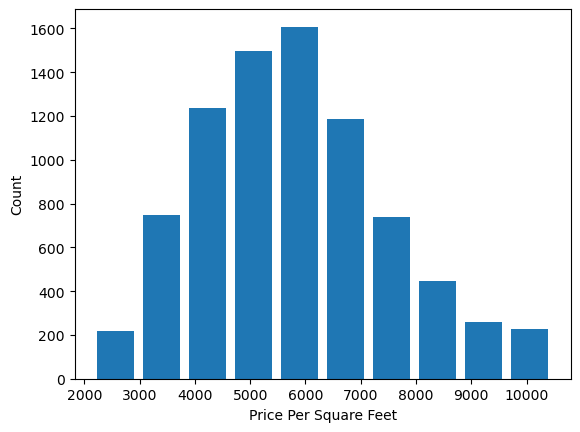

In [286]:
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

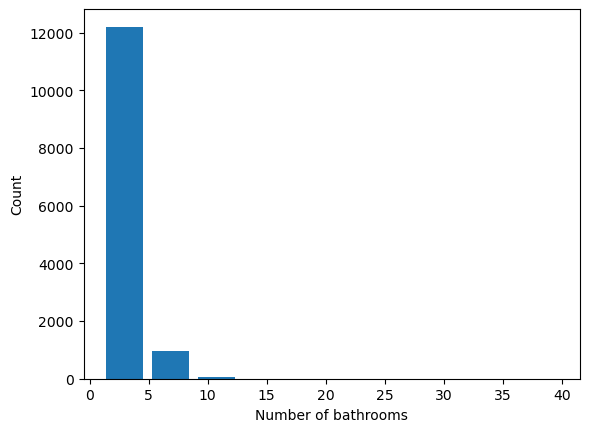

In [287]:
plt.hist(df.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [288]:
df7[df7.bath > df7.bhk + 2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
2620,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
7709,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
11366,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
12103,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330


It is unusual to have 2 more bathrooms than number of bedrooms in a home. So we are discarding that also.

In [289]:
df8 = df7[df7.bath <= df7.bhk + 2]

In [290]:
df8.shape

(8162, 7)

In [291]:
df9 = df8.drop(['size','price_per_sqft'],axis='columns')
df9.head(3)

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3


In [292]:
df9.location.value_counts()

location
other                   1081
Whitefield               267
Sarjapur  Road           241
Thanisandra              149
Hebbal                   145
                        ... 
Sarakki Nagar              3
Giri Nagar                 2
1st Block Jayanagar        2
2nd Stage Nagarbhavi       2
HAL 2nd Stage              1
Name: count, Length: 241, dtype: int64

In [293]:
temp = df9.drop(columns=['location'])

## Part 1.4 | Visualize correlations between features and the target variable

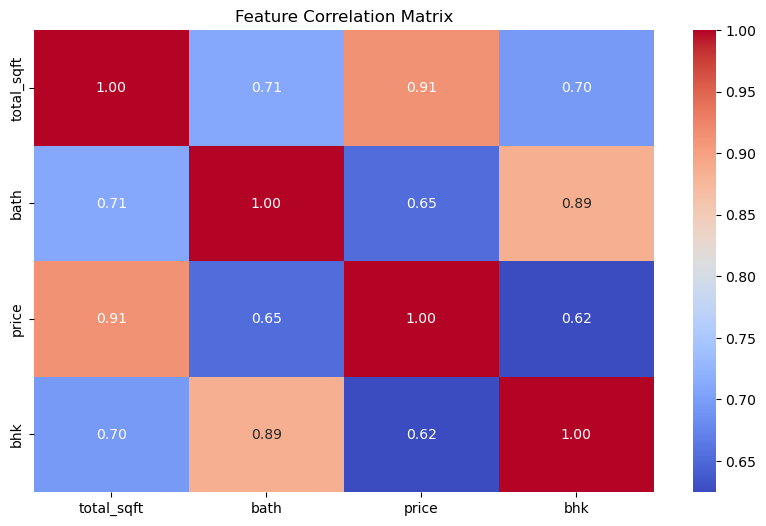

In [294]:
plt.figure(figsize=(10, 6))
sns.heatmap(temp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [295]:
df9.to_csv("Cleaned_data.csv")

# Part 2 | Model Training and Evaluation

## Part 2.1 | Split the dataset into training and testing sets

In [296]:
X = df9.drop(columns=['price'])
Y = df9['price']

In [297]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 10)

In [298]:
col_trans = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ['location']),  # Encode categorical feature
    (StandardScaler(), X_train.select_dtypes(include=['number']).columns),  # Scale numeric features
    remainder='passthrough'
)

In [299]:
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    return {'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}


## Part 2.2 | Model Training
## Part 2.3 | Model Evaluation
## Part 2.4 | Optimizing Model using GridSearchCV and RandomSearchCV

In [300]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "Catboosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoostRegressor": AdaBoostRegressor()
}

In [301]:
param_grids = {
    "Ridge": {'ridge__alpha': [0.01, 0.1, 1, 10, 100]},
    "Lasso": {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]},
    "K-Neighbors Regressor": {'kneighborsregressor__n_neighbors': [3, 5, 7, 9]},
    "Decision Tree Regressor": {'decisiontreeregressor__max_depth': [5, 10, 20, None]},
    "Random Forest Regressor": {
        'randomforestregressor__n_estimators': [100, 200, 500],
        'randomforestregressor__max_depth': [5, 10, 20, None]
    },
    "XGBRegressor": {
        'xgbregressor__n_estimators': [100, 300, 500],
        'xgbregressor__learning_rate': [0.01, 0.1, 0.3],
        'xgbregressor__max_depth': [3, 6, 9]
    },
    "CatBoost Regressor": {
        'catboostregressor__iterations': [100, 300, 500],
        'catboostregressor__depth': [4, 6, 10]
    }
}

In [302]:
best_models = {}
results = []

for name, model in models.items():
    print(f"Optimizing {name}...")
    pipe = make_pipeline(col_trans, model)
    
    if name in param_grids:
        search = RandomizedSearchCV(pipe, param_grids[name], n_iter=10, cv=5, scoring='r2', n_jobs=-1, random_state=42)
        search.fit(X_train, Y_train)
        best_models[name] = search.best_estimator_
        print(f"Best Params for {name}: {search.best_params_}")
    else:
        pipe.fit(X_train, Y_train)
        best_models[name] = pipe

    # Predict and evaluate
    Y_pred = best_models[name].predict(X_test)
    metrics = evaluate(Y_test, Y_pred)
    metrics['Model'] = name
    results.append(metrics)

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print(results_df)

Optimizing Linear Regression...
Optimizing Lasso...
Best Params for Lasso: {'lasso__alpha': 0.01}
Optimizing Ridge...
Best Params for Ridge: {'ridge__alpha': 1}
Optimizing K-Neighbors Regressor...
Best Params for K-Neighbors Regressor: {'kneighborsregressor__n_neighbors': 9}
Optimizing Decision Tree Regressor...
Best Params for Decision Tree Regressor: {'decisiontreeregressor__max_depth': 5}
Optimizing Random Forest Regressor...
Best Params for Random Forest Regressor: {'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_depth': None}
Optimizing XGBRegressor...
Best Params for XGBRegressor: {'xgbregressor__n_estimators': 300, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1}
Optimizing Catboosting Regressor...
Optimizing AdaBoostRegressor...
         MAE       RMSE  R2 Score                    Model
2  15.872617  24.525481  0.913829                    Ridge
1  15.981920  24.620358  0.913161                    Lasso
0  15.930996  24.620362  0.913161  

In [303]:
 best_models = {}
results = []

for name, model in models.items():
    print(f"Optimizing {name}...")
    pipe = make_pipeline(col_trans, model)
    
    if name in param_grids:
        search = GridSearchCV(pipe, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
        search.fit(X_train, Y_train)
        best_models[name] = search.best_estimator_
        print(f"Best Params for {name}: {search.best_params_}")
    else:
        pipe.fit(X_train, Y_train)
        best_models[name] = pipe

    # Predict and evaluate
    Y_pred = best_models[name].predict(X_test)
    metrics = evaluate(Y_test, Y_pred)
    metrics['Model'] = name
    results.append(metrics)

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R2 Score", ascending=False)
print(results_df)

Optimizing Linear Regression...
Optimizing Lasso...
Best Params for Lasso: {'lasso__alpha': 0.01}
Optimizing Ridge...
Best Params for Ridge: {'ridge__alpha': 1}
Optimizing K-Neighbors Regressor...
Best Params for K-Neighbors Regressor: {'kneighborsregressor__n_neighbors': 9}
Optimizing Decision Tree Regressor...
Best Params for Decision Tree Regressor: {'decisiontreeregressor__max_depth': 5}
Optimizing Random Forest Regressor...
Best Params for Random Forest Regressor: {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 500}
Optimizing XGBRegressor...
Best Params for XGBRegressor: {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 300}
Optimizing Catboosting Regressor...
Optimizing AdaBoostRegressor...
         MAE       RMSE  R2 Score                    Model
2  15.872617  24.525481  0.913829                    Ridge
1  15.981920  24.620358  0.913161                    Lasso
0  15.930996  24.620362  0.913161  

In [304]:
ridge_model = Ridge(alpha=1)
pipe = make_pipeline(col_trans,ridge_model)

In [305]:
pipe.fit(X_train,Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['location']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  Index(['total_sqft', 'bath', 'bhk'], dtype='object'))])),
                ('ridge', Ridge(alpha=1))])

In [306]:
Y_pred = pipe.predict(X_test)

In [307]:
metrics = evaluate(Y_test,Y_pred)

In [308]:
metrics

{'MAE': 15.872616892661895,
 'RMSE': 24.525480522067355,
 'R2 Score': 0.9138288878855392}

## Part 2.5 | Save the Model using Pickle

In [309]:
pickle.dump(pipe, open('RidgeModel.pkl','wb'))

In [310]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))